# Demo Flow Layers

> layers


In [1]:
#| default_exp demo.layers

In [2]:
#| hide
from nbdev.showdoc import *

In [3]:
#| hide
from IPython.display import clear_output, DisplayHandle

def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

In [4]:
 #| export

# from fastai.vision.all import nn, torch, np, Path, get_image_files, Image 
from fastai.vision.all import *
from fastai.data.all import *
import torch.nn.functional as F

import normflows as nf
from Noise2Model.utils import attributesFromDict

# Import required packages
import torchvision as tv

from matplotlib import pyplot as plt
from tqdm import tqdm


Now that we imported the necessary packages, we create a flow model.

Glow consists of `nf.flows.GlowBlocks`, that are arranged in a `nf.MultiscaleFlow`, following the multi-scale architecture. The base distribution is a `nf.distributions.ClassCondDiagGaussian`, which is a diagonal Gaussian with mean and standard deviation dependent on the class label of the image.


In [5]:
# Set up model

# Define flows
L = 3
K = 16
torch.manual_seed(0)

input_shape = (3, 32, 32)
n_dims = np.prod(input_shape)
channels = 3
hidden_channels = 256
split_mode = 'channel'
scale = True
num_classes = 10

# Set up flows, distributions and merge operations
q0 = []
merges = []
flows = []
for i in range(L):
    flows_ = []
    for j in range(K):
        flows_ += [nf.flows.GlowBlock(channels * 2 ** (L + 1 - i), hidden_channels,
                                     split_mode=split_mode, scale=scale)]
    flows_ += [nf.flows.Squeeze()]
    flows += [flows_]
    if i > 0:
        merges += [nf.flows.Merge()]
        latent_shape = (input_shape[0] * 2 ** (L - i), input_shape[1] // 2 ** (L - i), 
                        input_shape[2] // 2 ** (L - i))
    else:
        latent_shape = (input_shape[0] * 2 ** (L + 1), input_shape[1] // 2 ** L, 
                        input_shape[2] // 2 ** L)
    q0 += [nf.distributions.ClassCondDiagGaussian(latent_shape, num_classes)]


# Construct flow model with the multiscale architecture
model = nf.MultiscaleFlow(q0, flows, merges)

In [48]:
model

MultiscaleFlow(
  (q0): ModuleList(
    (0): ClassCondDiagGaussian()
    (1): ClassCondDiagGaussian()
    (2): ClassCondDiagGaussian()
  )
  (flows): ModuleList(
    (0): ModuleList(
      (0): GlowBlock(
        (flows): ModuleList(
          (0): AffineCouplingBlock(
            (flows): ModuleList(
              (0): Split()
              (1): AffineCoupling(
                (param_map): ConvNet2d(
                  (net): Sequential(
                    (0): Conv2d(24, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                    (1): LeakyReLU(negative_slope=0.0)
                    (2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
                    (3): LeakyReLU(negative_slope=0.0)
                    (4): Conv2d(256, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                  )
                )
              )
              (2): Merge()
            )
          )
          (1): Invertible1x1Conv()
          (2): ActNorm()
        )
      )
  

In [6]:
# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
model = model.to(device)

With torchvision we can download the CIFAR-10 dataset.


In [7]:
# Prepare training data
from fastai.callback.fp16 import *

path = untar_data(URLs.CIFAR)



In [8]:
(path).ls()

(#3) [Path('/home/biagio/.fastai/data/cifar10/labels.txt'),Path('/home/biagio/.fastai/data/cifar10/train'),Path('/home/biagio/.fastai/data/cifar10/test')]

In [26]:
path_train = os.path.join(path.__str__(), "train")
Path(path_train).ls()

(#10) [Path('/home/biagio/.fastai/data/cifar10/train/automobile'),Path('/home/biagio/.fastai/data/cifar10/train/cat'),Path('/home/biagio/.fastai/data/cifar10/train/horse'),Path('/home/biagio/.fastai/data/cifar10/train/ship'),Path('/home/biagio/.fastai/data/cifar10/train/airplane'),Path('/home/biagio/.fastai/data/cifar10/train/truck'),Path('/home/biagio/.fastai/data/cifar10/train/frog'),Path('/home/biagio/.fastai/data/cifar10/train/bird'),Path('/home/biagio/.fastai/data/cifar10/train/dog'),Path('/home/biagio/.fastai/data/cifar10/train/deer')]

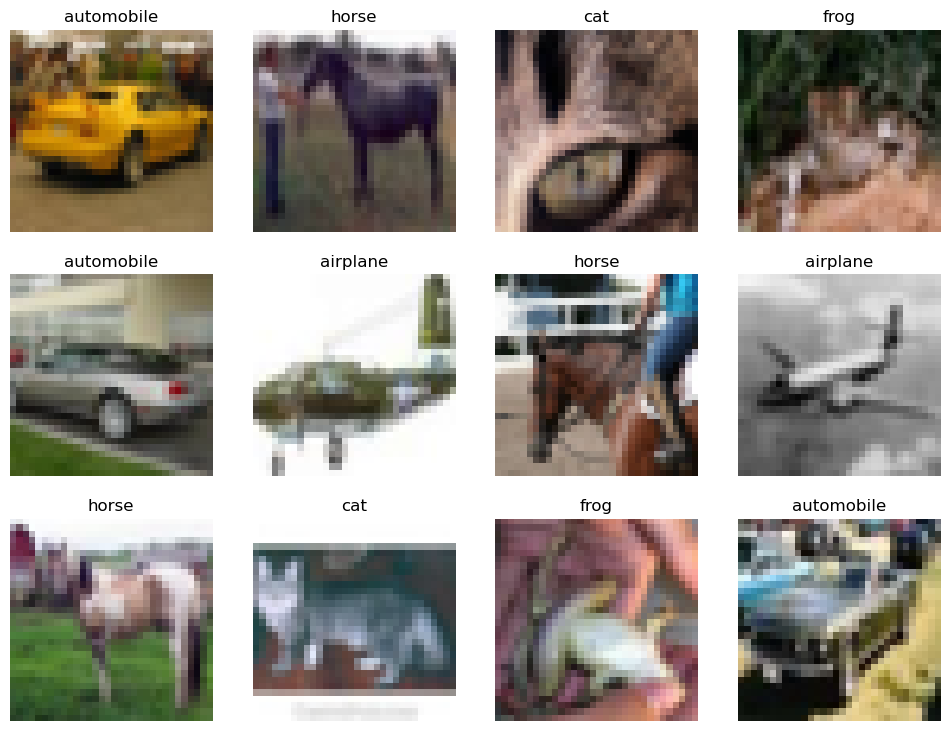

In [27]:
batch_size = 128

transform = tv.transforms.Compose([tv.transforms.ToTensor(), nf.utils.Scale(255. / 256.), nf.utils.Jitter(1 / 256.)])

data = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                    get_items=get_image_files,
                    get_y=parent_label,
                    )

dls = data.dataloaders(path_train, bs=batch_size, valid_pct=0.2, seed=42)

dls.valid.show_batch(max_n=12, nrows=3)


In [45]:
torch.mean(dls.one_batch()[0])

TensorImage(0.4756, device='cuda:0')

In [28]:
data.summary(path_train)

Setting-up type transforms pipelines
Found 50000 items
2 datasets of sizes 40000,10000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/biagio/.fastai/data/cifar10/train/horse/19062_horse.png
    applying PILBase.create gives
      PILImage mode=RGB size=32x32
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /home/biagio/.fastai/data/cifar10/train/horse/19062_horse.png
    applying parent_label gives
      horse
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(7)

Final sample: (PILImage mode=RGB size=32x32, TensorCategory(7))


Found 50000 items
2 datasets of sizes 40000,10000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Se

## Training


In [47]:
# learn = Learner(dls, model, loss_func= model.forward_kld())
# learn.summary()

TypeError: forward_kld() missing 1 required positional argument: 'x'

In [13]:
# learn.fit_one_cycle(1, lr_max=1e-03) #, cbs=cbs

In [14]:
# Train model
max_iter = 200

loss_hist = np.array([])

optimizer = torch.optim.Adamax(model.parameters(), lr=1e-3, weight_decay=1e-5)

for i in tqdm(range(max_iter)):
    try:
        x, y = next(train_iter)
    except:
        train_iter = iter(dls.train)
        x, y = next(train_iter)
    optimizer.zero_grad()
    loss = model.forward_kld(x.to(device), y.to(device))
        
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()

    loss_hist = np.append(loss_hist, loss.detach().to('cpu').numpy())

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:30<00:00,  6.54it/s]


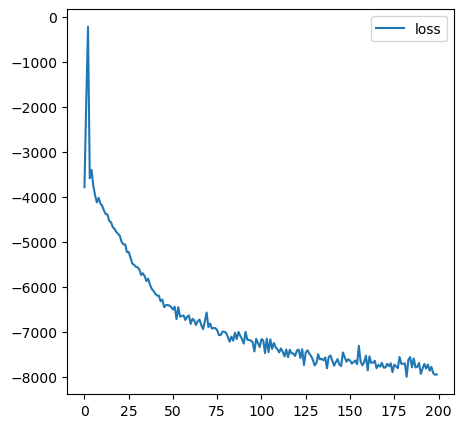

In [15]:
plt.figure(figsize=(5, 5))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

## Evaluation


/home/biagio/miniconda3/envs/n2m/lib/python3.9/site-packages/matplotlib/cm.py:317: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


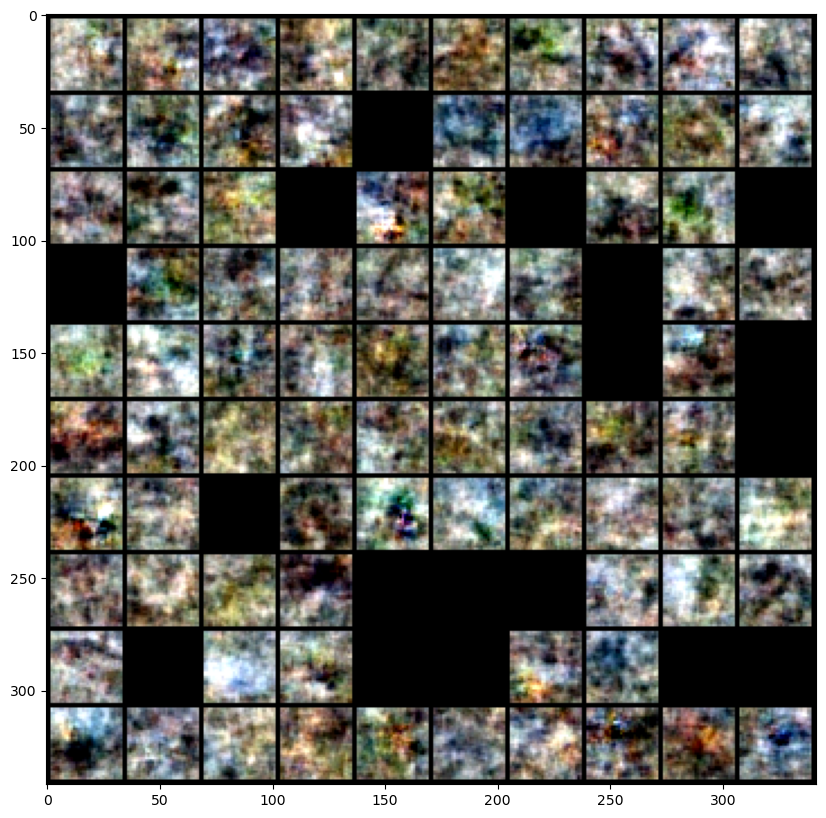

In [16]:
# Model samples
num_sample = 10

with torch.no_grad():
    y = torch.arange(num_classes).repeat(num_sample).to(device)
    x, _ = model.sample(y=y)
    x_ = torch.clamp(x, 0, 1)
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(tv.utils.make_grid(x_, nrow=num_classes).cpu().numpy(), (1, 2, 0)))
    plt.show()